In [1]:
import os

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import LearningCurveDisplay, StratifiedKFold, train_test_split

#### Wczytanie danych

In [2]:
train = pd.read_csv(os.path.join('prepared', 'train.csv'))
test = pd.read_csv(os.path.join('prepared', 'test.csv'))

test_to_drop = ['obs']
train_to_drop = ['salary_category']

my_categories = train.select_dtypes(exclude=['object', np.float64, np.bool_]).columns.tolist()
my_categories.append('job_title')
my_categories.append('feature_1')
train[my_categories] = train[my_categories].astype('category')
test[my_categories] = test[my_categories].astype('category')

test['is_others_job_title'] = test['is_others_job_title'].astype(int)
test['is_others_job_title'] = test['is_others_job_title'].astype('category')

test.drop(columns=test_to_drop, inplace=True)
train.drop(columns=train_to_drop, inplace=True)

#### Wstępne połączenie zbiorów

bo niżej jest ucinanie zakresu dla zbioru train

In [3]:
train['is_train'] = 1
test['is_train'] = 0
whole = pd.concat([train, test], axis=0, ignore_index=True).reset_index(drop=True)

whole['is_train'].value_counts()

is_train
1    1280
0     854
Name: count, dtype: int64

#### Połączenie zbiorów

In [4]:
whole = pd.concat([train, test], axis=0, ignore_index=True).reset_index(drop=True)

#### Proces nauki, walidacji

In [5]:
X, y = whole.drop(columns=['is_train'], axis=1), whole['is_train']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [6]:
# def define_model(trial):
#     params = {
#         'objective': 'binary',
#         'boosting': 'gbdt',
#         'device': 'cpu',
#         'n_jobs': -1,
#         'random_state': 42,
#         'verbosity': -1,
#         'max_bin': trial.suggest_int('max_bin', 70, 250),
#         'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
#         'n_estimators': trial.suggest_int('n_estimators', 10, 150),
#         'num_leaves': trial.suggest_int('num_leaves', 2, 128),
#         'max_depth': trial.suggest_int('max_depth', 2, 20),
#         'reg_alpha': trial.suggest_float('reg_alpha', 1e-2, 1, log=True),
#         'reg_lambda': trial.suggest_float('reg_lambda', 1e-2, 1, log=True),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#     }
#     return lgb.LGBMClassifier(**params)
#
# def objective(trial):
#     model = define_model(trial)
#     skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
#     scores = cross_val_score(model, X_train, y_train, cv=skf, n_jobs=-1, scoring='f1_weighted')
#     return scores.mean()
#
# study_lightgbm = optuna.create_study(direction='maximize', study_name='EngineerSalaryLightGBM', sampler=optuna.samplers.TPESampler())
# study_lightgbm.optimize(objective, n_trials=50)

In [7]:
lightgbm = lgb.LGBMClassifier(**{
    'objective': 'binary',
    'boosting': 'gbdt',
    'learning_rate': 0.02,
    'n_estimators': 100,
    'num_leaves': 16,
    'max_depth': 10,
    'reg_alpha': 1e-3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'n_jobs': -1,
    'random_state': 42,
    'verbose': -1,
    'class_weight': 'balanced'
    ''
}).fit(X_train, y_train)
lightgbm_pred = lightgbm.predict(X_test)

print(classification_report(y_test, lightgbm_pred))

              precision    recall  f1-score   support

           0       0.62      0.51      0.56       171
           1       0.71      0.79      0.75       256

    accuracy                           0.68       427
   macro avg       0.66      0.65      0.65       427
weighted avg       0.67      0.68      0.67       427



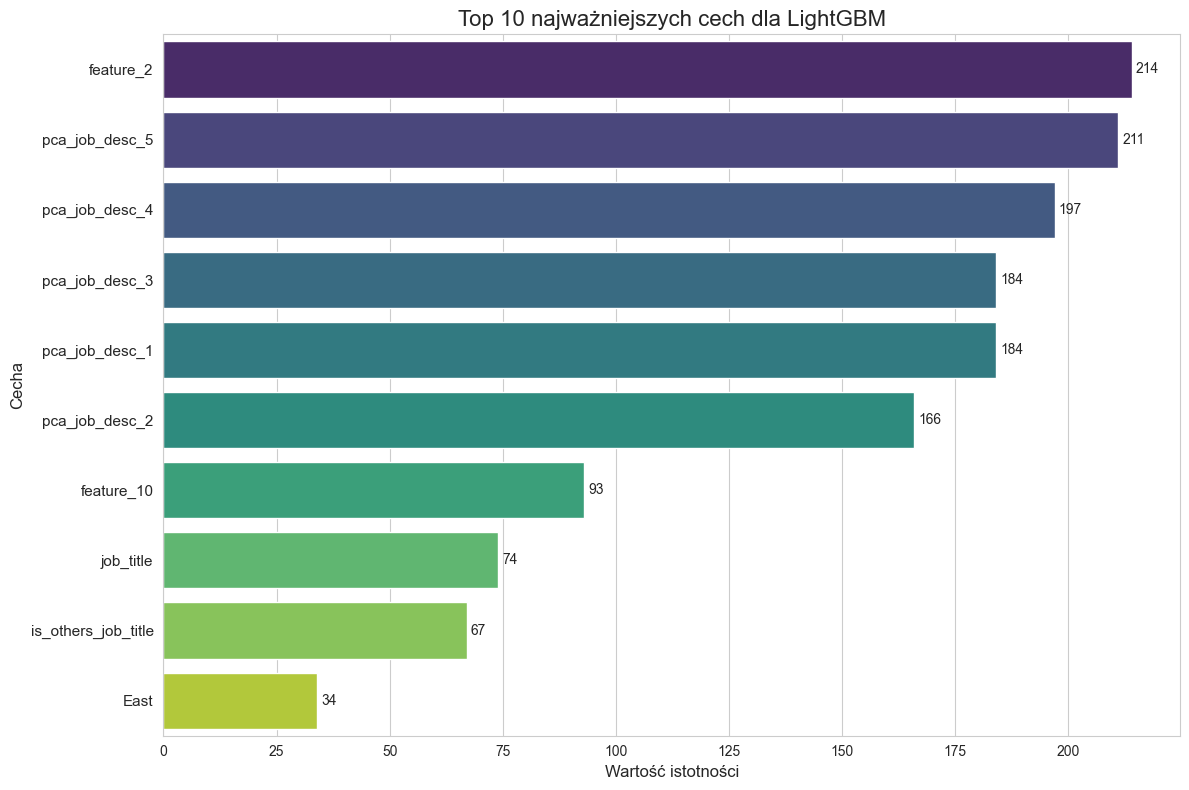

In [8]:
lightgbm_importance = pd.DataFrame(
    data={
        'feature': lightgbm.feature_name_,
        'importance': lightgbm.feature_importances_
    }).sort_values(by='importance', ascending=False).head(10)

plt.figure(figsize=(12, 8))
sns.set_style('whitegrid')

ax = sns.barplot(
    data=lightgbm_importance,
    x='importance',
    y='feature',
    hue='feature',
    legend=False,
    palette='viridis'
)

for i in ax.containers:
    ax.bar_label(i, fmt='%g', label_type='edge', fontsize=10, padding=3)

plt.title('Top 10 najważniejszych cech dla LightGBM', fontsize=16)
plt.xlabel('Wartość istotności', fontsize=12)
plt.ylabel('Cecha', fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()

<Axes: >

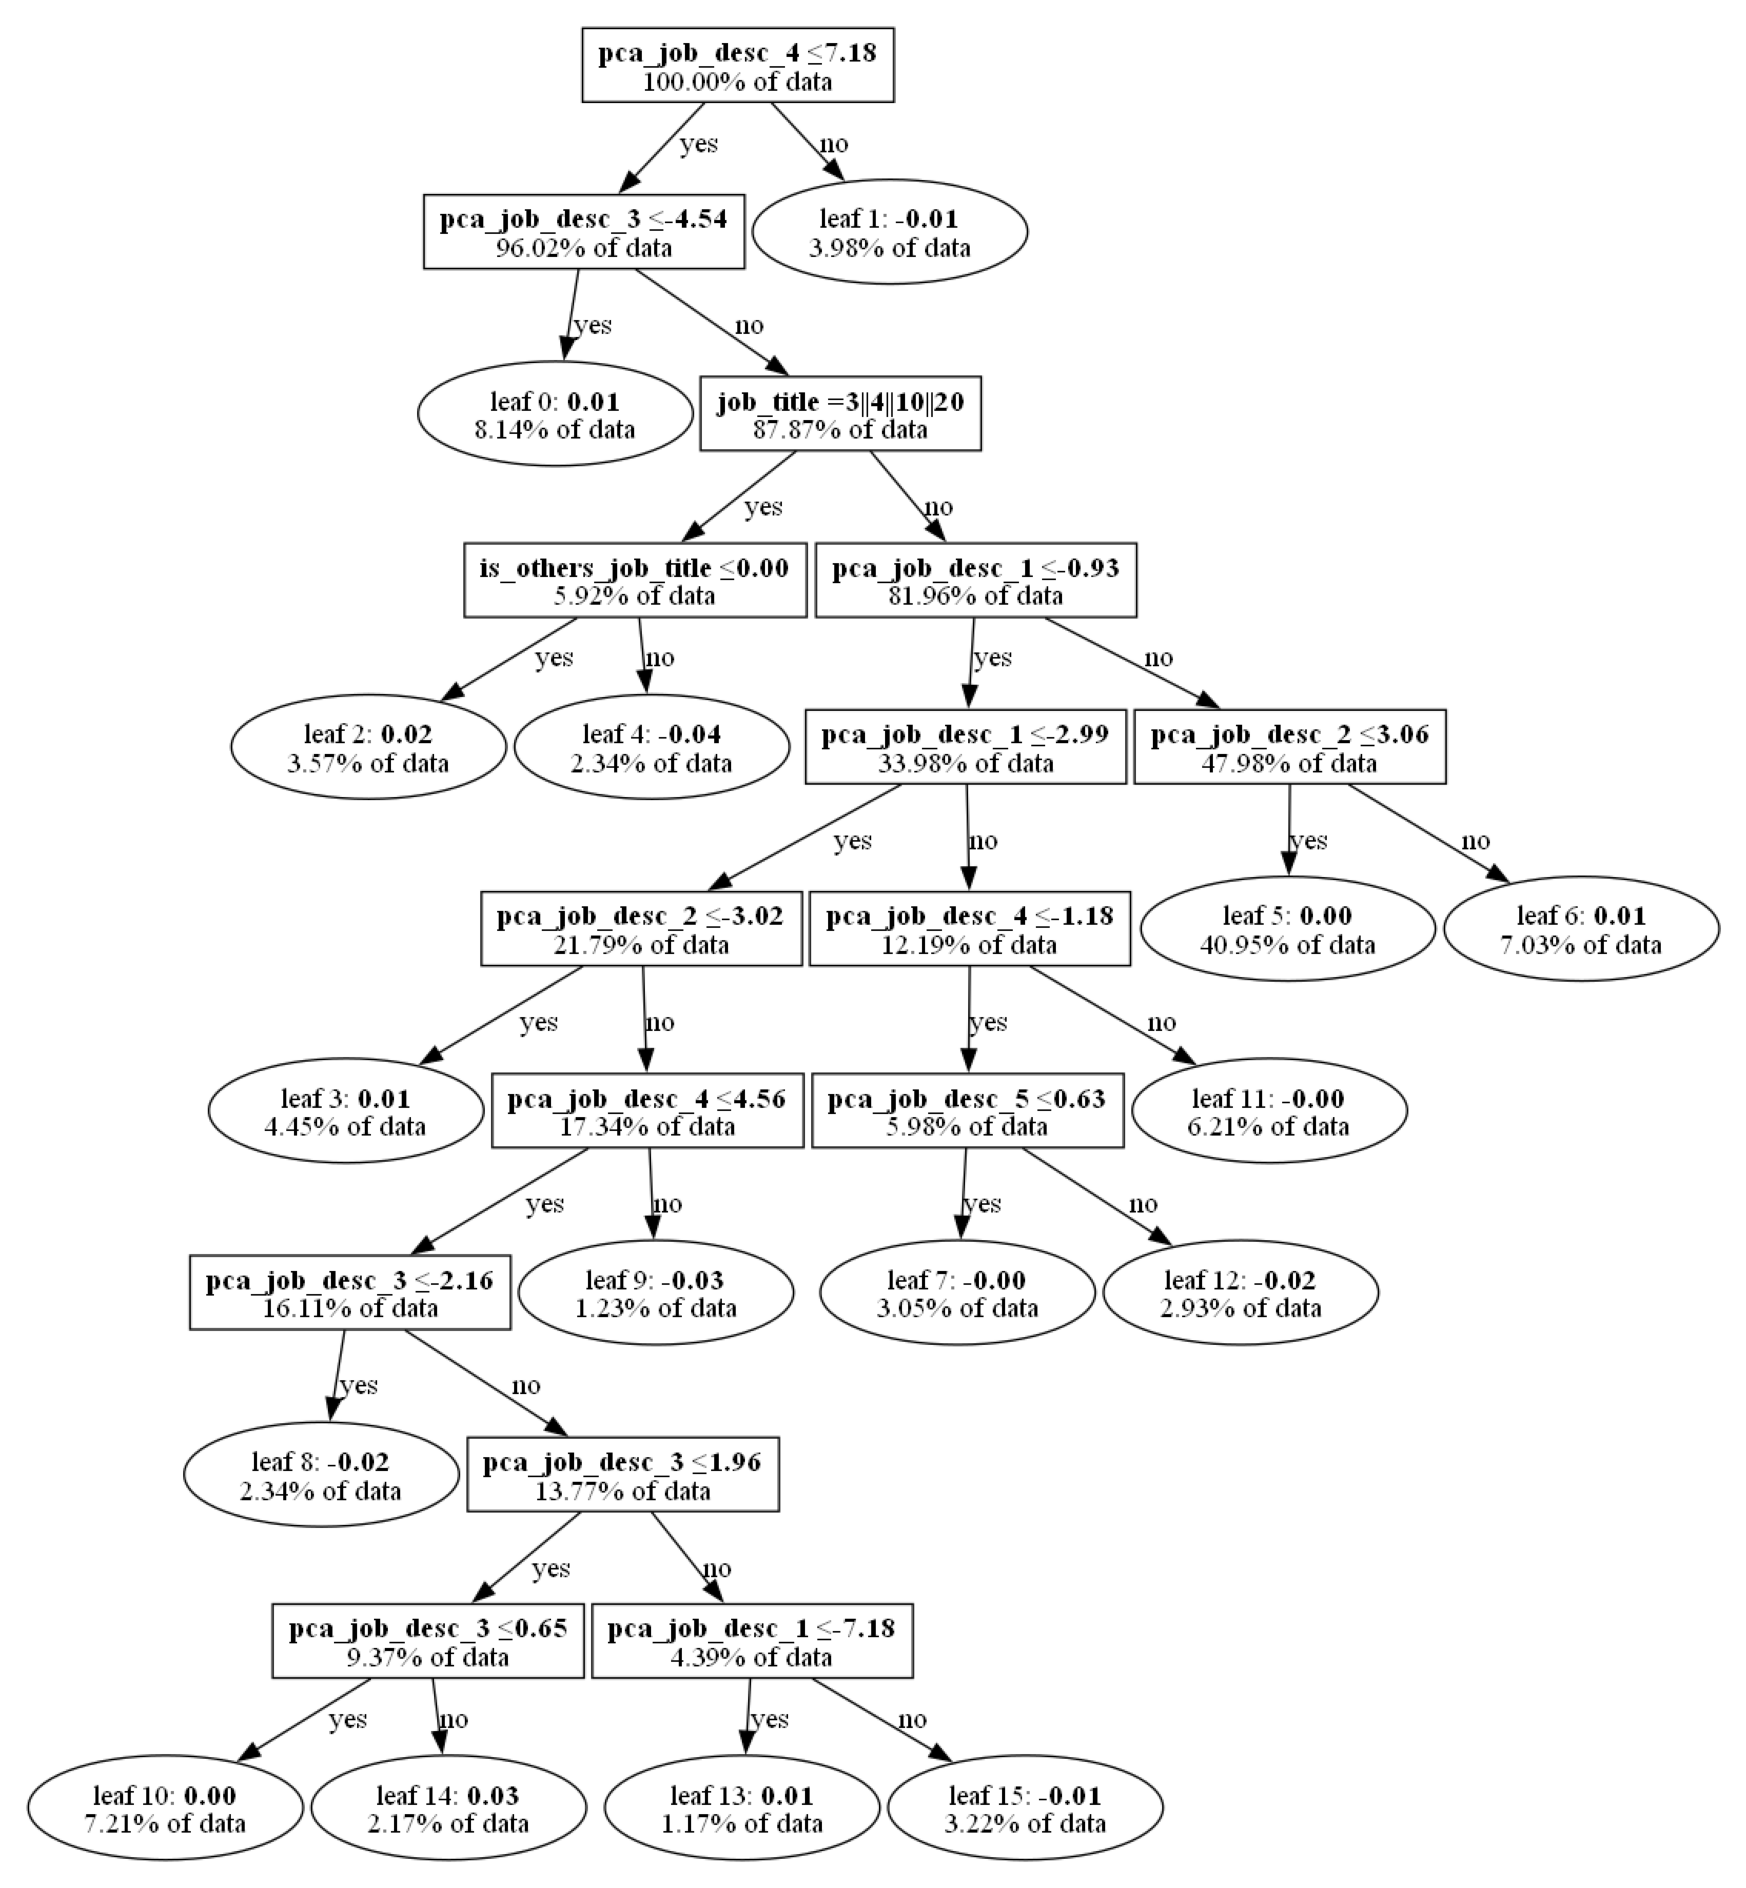

In [9]:
lgb.plot_tree(lightgbm, precision=2, figsize=(20, 12), show_info=['data_percentage'], dpi=200, orientation='vertical')

#### Macierz pomyłek

Text(50.722222222222214, 0.5, 'Przewidziane etykiety')

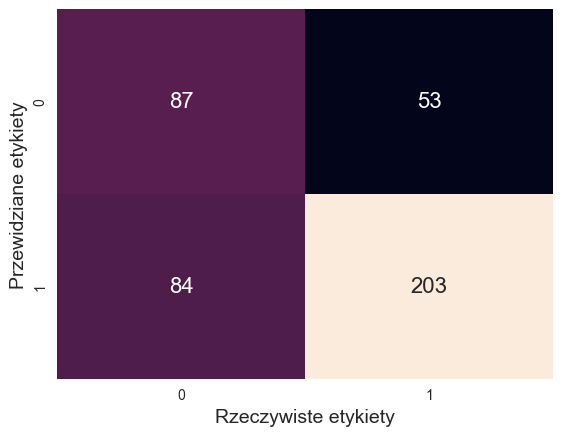

In [10]:
conf_matrix = confusion_matrix(y_test, lightgbm_pred)
sns.heatmap(
    conf_matrix.T,
    annot=True,
    fmt='d',
    cbar=False,
    cmap='rocket',
    annot_kws={'size': 16}
)
plt.xlabel('Rzeczywiste etykiety', fontdict={'fontsize': 14})
plt.ylabel('Przewidziane etykiety', fontdict={'fontsize': 14})

#### Krzywa uczenia

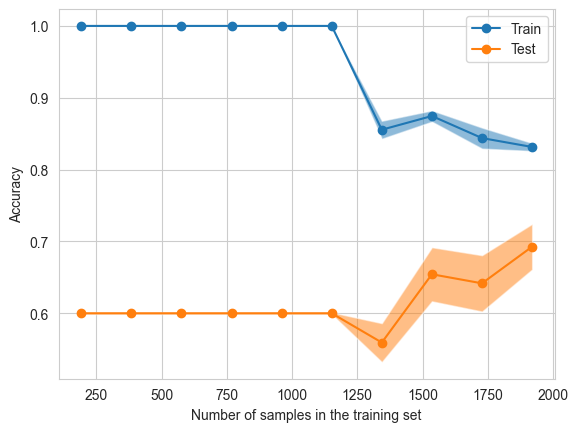

In [11]:
LearningCurveDisplay.from_estimator(
    estimator=lightgbm,
    X=X,
    y=y,
    cv=10,
    n_jobs=-1,
    random_state=42,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    line_kw= {'marker': 'o'}
)